In [88]:
def mainode(t,x):
    # global variables:
    # N is number of neurons
    # Wij is the synpatic efficancy from neuron j to i
    # sigma2_w is the variance of W
    # x_tilde is the recall cue
    # k_{prior,noise} is the concentration of prior and 
    # cue distribution
    # x_fire is list of each neuron's list of firing 
    # phase, dynamically updated at each event
    H = np.zeros((N,N))
    for j in range(N):
        if x_fire[j]: # if neuron j has fired
            xj = x_fire[j][-1] # we need the last firing phase
            dxij = x-xj # phase difference between neurons
            H[:,j] = W[:,j] * domega(dxij) # phase interaction
                                           # from neuron j
                                           # to neuron i
                                           # Hjj is guarenteed
                                           # to be 0 because
                                           # Wjj is 0
    dx_prior    = -k_prior * np.sin(x) 
    dx_external = -k_noise * np.sin(x-x_tilde)
    dx_synapse  = np.sum(H,1)/sigma2_w # sum_j H_{ij}/sigma_w^2
    return dx_prior + dx_external + dx_synapse


In [89]:
N = 200	# number of neurons
event = [lambda t,x,j=j: np.sin((x[j]-t)/2) for j in range(N)]      
        # event[i](t,x)
        # equals 0 when firing phase
        # of neuron i matches current LFP 
        # i.e. (x[i]-t) mod 2pi ==0   
        # syntax: j=j freeze j google "python define list of function"                              

In [90]:
N = N	# number of neurons
M = 15	# number of memories
k_prior = 0.5	# von Mises concentration parameter
                # for prior distribution
k_noise = 10	# for cue distribution
x_memory = np.random.vonmises(0,k_prior,(N,M)) # every column 
                                        # is a memory trace
x_target = x_memory[:,0].copy()     # the first one is 
                                    # what we want to recall
x_0 = x_target.copy()               # stability check
x_noise = np.random.vonmises(0,k_noise,N)   # indepedent random
                                # noise to corrupt the cue
x_tilde = x_target + x_noise 
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # j<i, Wii = 0
        for k in range(M): # the STDP rule is additive
            W[i,j] += omega(x_memory[i,k]-x_memory[j,k])
            W[j,i] += omega(x_memory[j,k]-x_memory[i,k])
W_flatten = [W[i][j] for i in range(N) for j in range(i) ]
sigma2_w = np.var(W_flatten)
# plt.hist(W_flatten,50)

x_fire = [[ ] for j in range(N)] # record firing phase


In [91]:
for func in event: 
        func.terminal = True # stop integration when any neuron fires
# first round
tf = 10*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
print(sol.message)
print(tNow)
# print(len(xNow))

155
A termination event occurred.
0.004237735805718362


In [92]:
while tNow < tf:
        sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
        t = np.append(t,sol.t)          # integrate until one neuron
        x = np.append(x,sol.y,axis=1)   # fires, record time, state,
        tNow = t[-1]                    # firing time and neuron
        xNow = x[:,-1]                  # index
        whoFire = []
        for j,te in enumerate(sol.t_events): 
                event[j].terminal = True 
                if te.size>0:
                        event[j].terminal = False
                        if (not x_fire[j]) or te[0]>x_fire[j][-1]+1e-5: # 'refractory' to prevent overcounting spikes
                                whoFire += [j]
                                x_fire[j] += list(te)  # update x_fire for calculating H
        if 0 in whoFire:
                print(sol.message)
                print(tNow)

A termination event occurred.
5.1496550619852


A termination event occurred.
5.18942931454983


A termination event occurred.
5.7609294797175465


A termination event occurred.
5.778594392169172


A termination event occurred.
5.8424707638511


A termination event occurred.
12.008413792912192


A termination event occurred.
18.235300901642923


A termination event occurred.
24.48364947813433


A termination event occurred.
30.74745400977192


Text(0,0.5,'counts')

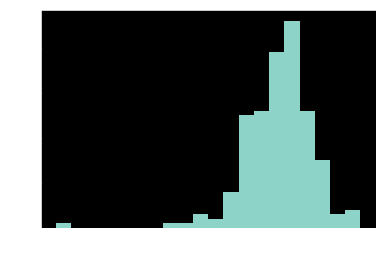

In [93]:
finalPhase = [ x_fire[i][-1] for i in range(N) ]
errors = np.array(finalPhase) - x_target
errors = np.mod(errors+np.pi,2*np.pi)-np.pi
plt.hist(errors,20)
plt.xlabel('errors')
plt.ylabel('counts')

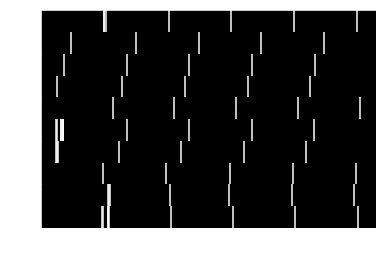

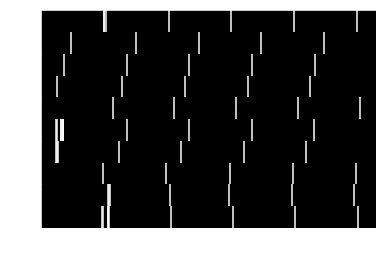

In [94]:
def raster(x_fire,inds):
        nn = len(inds)
        tf=0
        fig,ax = plt.subplots()
        for i in inds:
                for te in x_fire[i]:
                        ax.vlines(te,i,i+1,color='white')
                if tf<te: tf=te
        ax.set_ylim(0,nn)
        ax.set_xlabel('time in LFP cycle')
        ax.set_ylabel('neuron')
        xticks = np.arange(0,tf+2*np.pi,2*np.pi)
        ax.set_xticks(xticks)
        ax.set_xticklabels(map(str,range(len(xticks))))
        # fig.show()
        return fig
raster(x_fire,range(10))

(array([1.517e+03, 3.090e+02, 2.610e+02, 1.058e+03, 3.650e+02, 1.440e+02,
        3.500e+01, 1.000e+01, 5.000e+00, 1.000e+00]),
 array([0.        , 0.00397197, 0.00794394, 0.01191591, 0.01588787,
        0.01985984, 0.02383181, 0.02780378, 0.03177575, 0.03574772,
        0.03971969]),
 <a list of 10 Patch objects>)

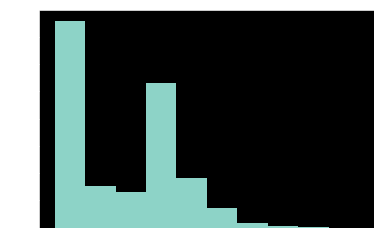

In [95]:
plt.hist(np.diff(t))

(array([5., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.        , 0.00042377, 0.00084755, 0.00127132, 0.00169509,
        0.00211887, 0.00254264, 0.00296642, 0.00339019, 0.00381396,
        0.00423774]),
 <a list of 10 Patch objects>)

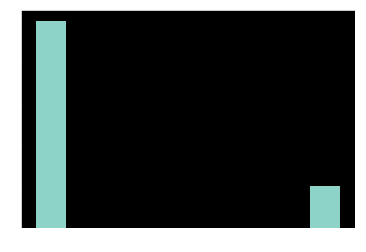

In [96]:
plt.hist(np.diff(t[t<.005]))

(array([1204.,   49.,   50.,   44.,   39.,   36.,   45.,   51.,   39.,
          41.]),
 array([0.        , 0.0004991 , 0.00099819, 0.00149729, 0.00199639,
        0.00249548, 0.00299458, 0.00349368, 0.00399277, 0.00449187,
        0.00499097]),
 <a list of 10 Patch objects>)

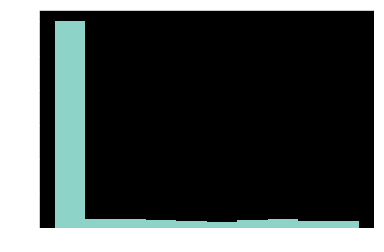

In [97]:
temp = np.diff(t)
plt.hist(temp[temp<0.005])

In [98]:

np.save('x_12120044_discontinous_xj',x)
np.save('x_target_12120044_discontinous_xj',x_target)
np.save('x_fire_12120044_discontinous_xj',x_fire)
np.save('t_12120044_discontinous_xj',t)

In [99]:
N = N	# number of neurons
M = 15	# number of memories
k_prior = 0.5	# von Mises concentration parameter
                # for prior distribution
k_noise = 10	# for cue distribution
x_memory = np.random.vonmises(0,k_prior,(N,M)) # every column 
                                        # is a memory trace
x_target = x_memory[:,0].copy()     # the first one is 
                                    # what we want to recall
x_0 = np.random.vonmises(0,k_prior,N)
x_noise = np.random.vonmises(0,k_noise,N)   # indepedent random
                                # noise to corrupt the cue
x_tilde = x_target + x_noise 
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # j<i, Wii = 0
        for k in range(M): # the STDP rule is additive
            W[i,j] += omega(x_memory[i,k]-x_memory[j,k])
            W[j,i] += omega(x_memory[j,k]-x_memory[i,k])
W_flatten = [W[i][j] for i in range(N) for j in range(i) ]
sigma2_w = np.var(W_flatten)
# plt.hist(W_flatten,50)

x_fire = [[ ] for j in range(N)] # record firing phase


In [100]:
print(not np.any(np.diag(W)))
i,j = np.random.randint(0,N,2)
print(W[i,j] + W[j,i] == 0)

True
True


In [101]:
for func in event: 
        func.terminal = True # stop integration when any neuron fires
# first round
tf = 10*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
print(sol.message)
print(tNow)
# print(len(xNow))

190
A termination event occurred.
0.010073929988627158


In [102]:
for func in event: 
        func.terminal = True # stop integration when any neuron fires
# first round
tf = 10*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
print(sol.message)
print(tNow)
# print(len(xNow))

198
A termination event occurred.
0.004412964931718131


In [103]:
for func in event: 
        func.terminal = True # stop integration when any neuron fires
# first round
tf = 10*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
print(sol.message)
print(tNow)
# print(len(xNow))

198
A termination event occurred.
0.0044129379454559805


In [104]:
x_fire = [[ ] for j in range(N)] # record firing phase
for func in event: 
        func.terminal = True # stop integration when any neuron fires
# first round
tf = 10*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
print(sol.message)
print(tNow)
# print(len(xNow))

190
A termination event occurred.
0.010073929988627158


In [105]:
x_fire = [[ ] for j in range(N)] # record firing phase
for func in event: 
        func.terminal = True # stop integration when any neuron fires
# first round
tf = 10*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
print(sol.message)
print(tNow)
# print(len(xNow))

190
A termination event occurred.
0.010073929988627158


In [106]:
while tNow < tf:
        sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
        t = np.append(t,sol.t)          # integrate until one neuron
        x = np.append(x,sol.y,axis=1)   # fires, record time, state,
        tNow = t[-1]                    # firing time and neuron
        xNow = x[:,-1]                  # index
        whoFire = []
        for j,te in enumerate(sol.t_events): 
                event[j].terminal = True 
                if te.size>0:
                        event[j].terminal = False
                        if (not x_fire[j]) or te[0]>x_fire[j][-1]+1e-5: # 'refractory' to prevent overcounting spikes
                                whoFire += [j]
                                x_fire[j] += list(te)  # update x_fire for calculating H
        if 0 in whoFire:
                print(sol.message)
                print(tNow)

A termination event occurred.
1.3153517036504865


A termination event occurred.
7.528266930294198


A termination event occurred.
13.734822265725557


A termination event occurred.
20.03190891254945


A termination event occurred.
26.298713919311986


Text(0,0.5,'counts')

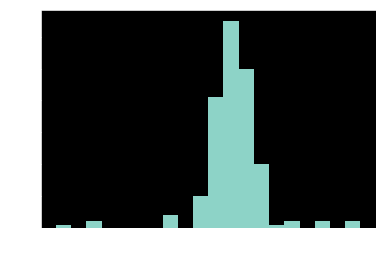

In [107]:
finalPhase = [ x_fire[i][-1] for i in range(N) ]
errors = np.array(finalPhase) - x_target
errors = np.mod(errors+np.pi,2*np.pi)-np.pi
plt.hist(errors,20)
plt.xlabel('errors')
plt.ylabel('counts')

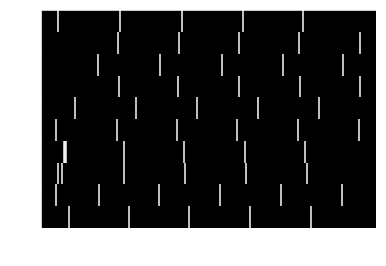

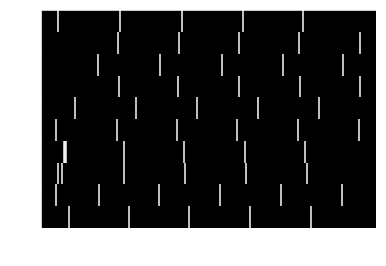

In [108]:
def raster(x_fire,inds):
        nn = len(inds)
        tf=0
        fig,ax = plt.subplots()
        for i in inds:
                for te in x_fire[i]:
                        ax.vlines(te,i,i+1,color='white')
                if tf<te: tf=te
        ax.set_ylim(0,nn)
        ax.set_xlabel('time in LFP cycle')
        ax.set_ylabel('neuron')
        xticks = np.arange(0,tf+2*np.pi,2*np.pi)
        ax.set_xticks(xticks)
        ax.set_xticklabels(map(str,range(len(xticks))))
        # fig.show()
        return fig
raster(x_fire,range(10))